In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from matplotlib.colors import SymLogNorm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from lightgbm import LGBMClassifier

In [22]:
df_original = pd.read_csv("healthcare-dataset-stroke-data.csv")

df_train = pd.read_csv('train.csv')

df_test = pd.read_csv('test.csv')

df_submission = pd.read_csv('sample_submission.csv')


df_test['stroke'] = np.nan

In [23]:
df_original.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [24]:
df_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [25]:
df_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown,NaN
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown,NaN
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown,NaN
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes,NaN
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes,NaN


In [26]:
df_original.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [27]:
s = (df_original.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [28]:
print('missing value')

print('\n------- train -------\n')

print(df_train.isna().sum())

print('\n------- test  -------\n')

print(df_test.isna().sum())

print('\n------- original -------\n')

print(df_original.isna().sum())

missing value

------- train -------

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

------- test  -------

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                      0
smoking_status           0
stroke               10204
dtype: int64

------- original -------

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke    

In [29]:
df_original.describe(include='all').T # T stands for transpose

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5110.0,NaN,NaN,NaN,36517.829354,21161.721625,67.0,17741.25,36932.0,54682.0,72940.0
gender,5110,3,Female,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5110.0,NaN,NaN,NaN,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
hypertension,5110.0,NaN,NaN,NaN,0.097456,0.296607,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,NaN,NaN,NaN,0.054012,0.226063,0.0,0.0,0.0,0.0,1.0
ever_married,5110,2,Yes,3353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,5110,5,Private,2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,5110,2,Urban,2596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,5110.0,NaN,NaN,NaN,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,NaN,NaN,NaN,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6


In [30]:
df_original.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5110.0,NaN,NaN,NaN,36517.829354,21161.721625,67.0,17741.25,36932.0,54682.0,72940.0
gender,5110,3,Female,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5110.0,NaN,NaN,NaN,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
hypertension,5110.0,NaN,NaN,NaN,0.097456,0.296607,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,NaN,NaN,NaN,0.054012,0.226063,0.0,0.0,0.0,0.0,1.0
ever_married,5110,2,Yes,3353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,5110,5,Private,2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,5110,2,Urban,2596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,5110.0,NaN,NaN,NaN,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,NaN,NaN,NaN,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6


In [31]:
print('unique value counts')

print('\n------- train -------\n')

for i in df_train.columns:
    print(f'{i} : {df_train[i].nunique()}')

print('\n------- test  -------\n')

for i in df_test.columns:
    print(f'{i} : {df_test[i].nunique()}')

print('\n------- original -------\n')

for i in df_original.columns:
    print(f'{i} : {df_original[i].nunique()}')

unique value counts

------- train -------

id : 15304
gender : 3
age : 106
hypertension : 2
heart_disease : 2
ever_married : 2
work_type : 5
Residence_type : 2
avg_glucose_level : 3740
bmi : 407
smoking_status : 4
stroke : 2

------- test  -------

id : 10204
gender : 3
age : 106
hypertension : 2
heart_disease : 2
ever_married : 2
work_type : 5
Residence_type : 2
avg_glucose_level : 3265
bmi : 400
smoking_status : 4
stroke : 0

------- original -------

id : 5110
gender : 3
age : 104
hypertension : 2
heart_disease : 2
ever_married : 2
work_type : 5
Residence_type : 2
avg_glucose_level : 3979
bmi : 418
smoking_status : 4
stroke : 2


<AxesSubplot:xlabel='gender', ylabel='count'>

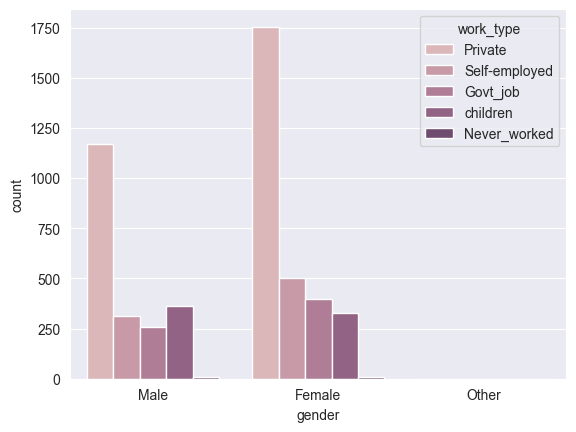

In [32]:
sns.set_palette(sns.cubehelix_palette(dark=.25, light=.75))
sns.countplot(data = df_original, x = 'gender', hue = "work_type")

<AxesSubplot:xlabel='gender', ylabel='count'>

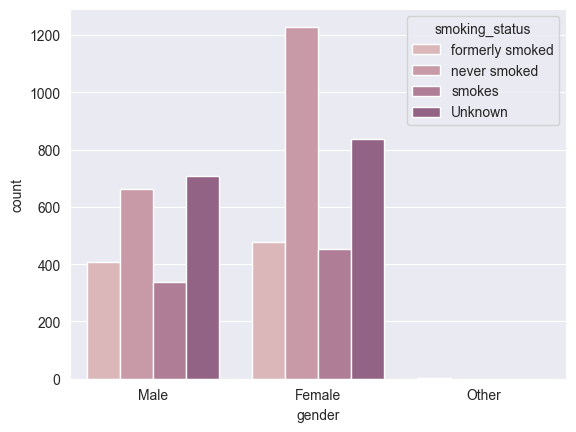

In [33]:
sns.countplot(data = df_original, x = "gender", hue = "smoking_status")

<AxesSubplot:xlabel='age', ylabel='Count'>

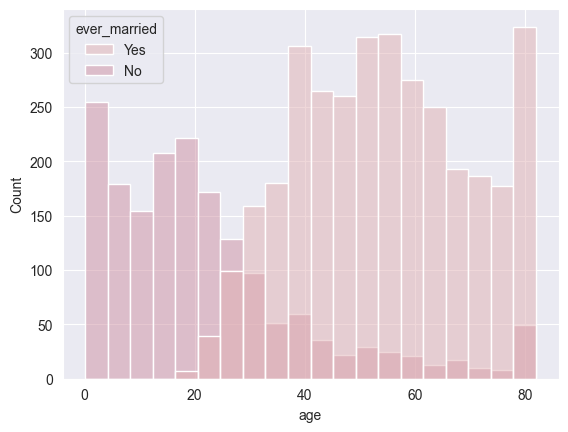

In [34]:
sns.histplot(data = df_original, x = 'age', hue = "ever_married")

<AxesSubplot:xlabel='bmi', ylabel='age'>

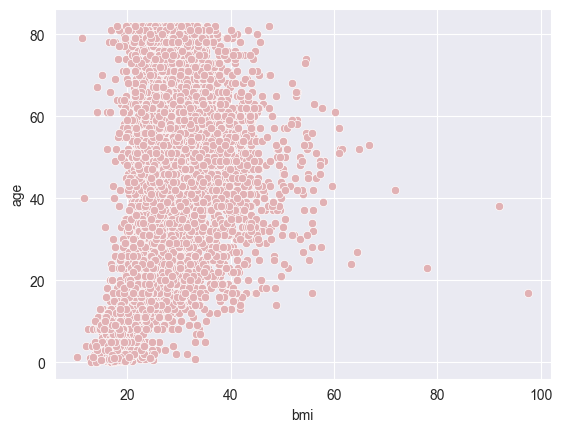

In [35]:
sns.scatterplot(x=df_original['bmi'], y= df_original['age'])

<AxesSubplot:xlabel='age', ylabel='Count'>

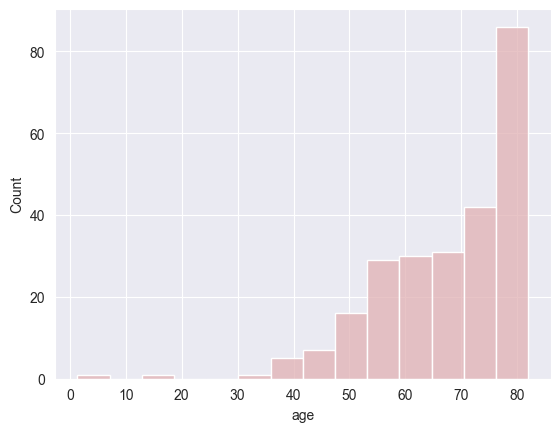

In [36]:
sns.histplot(data = df_original[df_original['stroke'] == 1].age)

<AxesSubplot:xlabel='stroke', ylabel='count'>

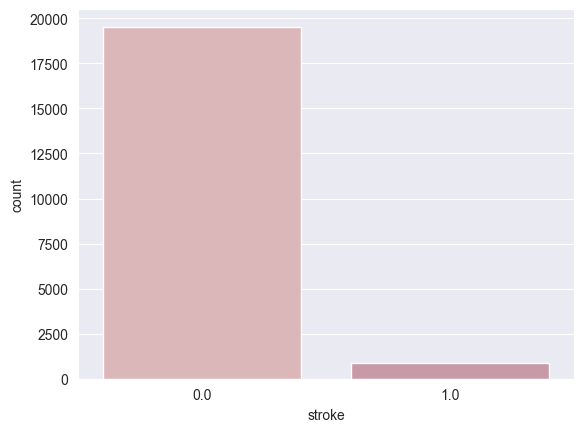

In [37]:
df = pd.concat([df_train, df_original, df_test], ignore_index=True, sort=False)
# we merged the databases
sns.countplot(data = df, x = 'stroke')

<AxesSubplot:>

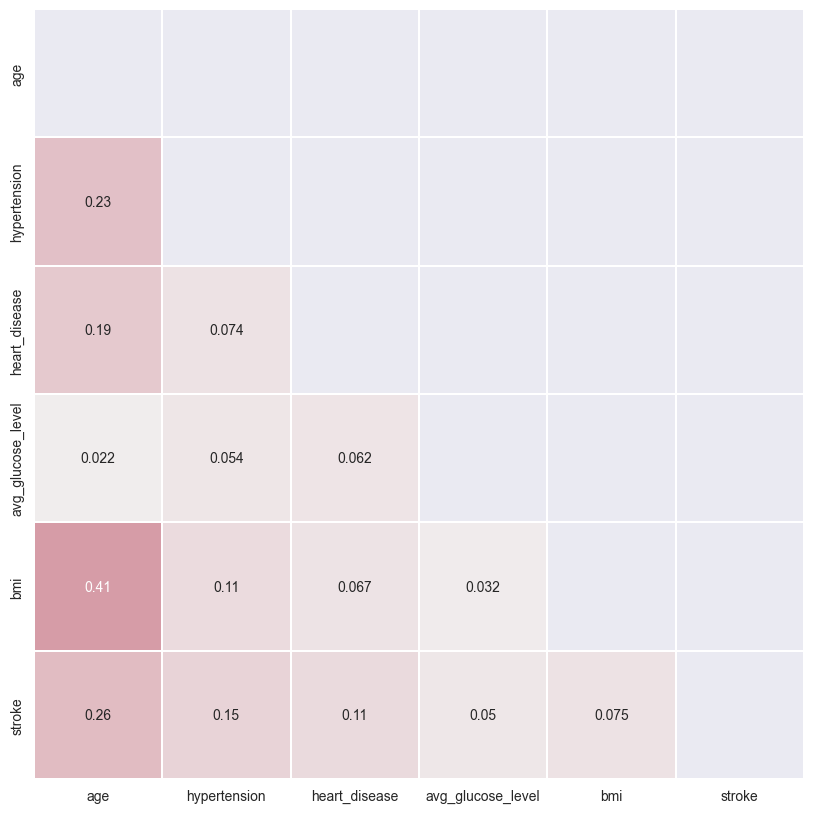

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
correlation_matrix = df_train.drop(['id'],axis=1).corr(method='spearman')
sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(290, 360, s=45, l=70, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)

C:\Users\Mehmet Arif\AppData\Local\Temp\ipykernel_20936\927454234.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_original['avg_glucose_level'], kde = False, color =colors[2], bins = 30)


<AxesSubplot:xlabel='avg_glucose_level'>

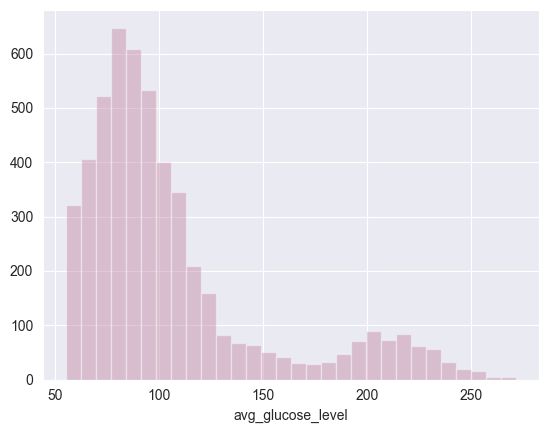

In [39]:
colors = sns.cubehelix_palette()

sns.distplot(df_original['avg_glucose_level'], kde = False, color =colors[2], bins = 30)

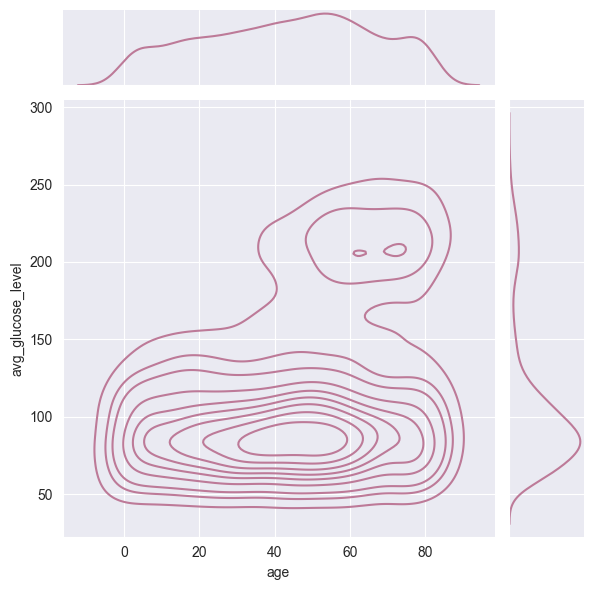

In [40]:
sns.jointplot(x ='age', y ='avg_glucose_level', data = df_original, kind ='kde', color = colors[2])

C:\Users\Mehmet Arif\AppData\Local\Temp\ipykernel_20936\1607617263.py:1: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.displot(df_original, x="avg_glucose_level", hue="gender", kind="kde", palette = [colors[2], colors[5]])
C:\Users\Mehmet Arif\AppData\Local\Temp\ipykernel_20936\1607617263.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(df_original, x="avg_glucose_level", hue="gender", kind="kde", palette = [colors[2], colors[5]])


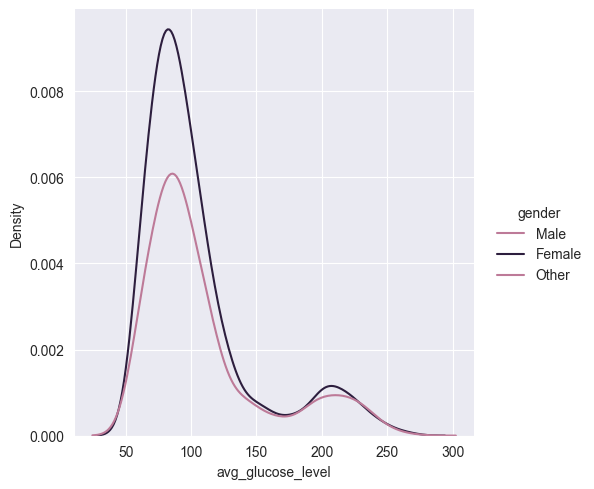

In [41]:
sns.displot(df_original, x="avg_glucose_level", hue="gender", kind="kde", palette = [colors[2], colors[5]])

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

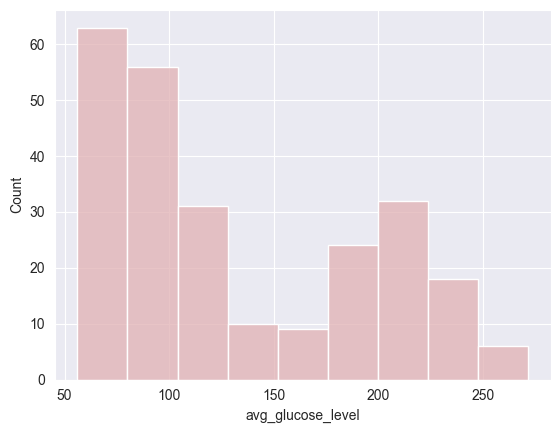

In [42]:
sns.histplot(data = df_original[df_original['stroke'] == 1].avg_glucose_level)

<AxesSubplot:xlabel='ever_married', ylabel='Count'>

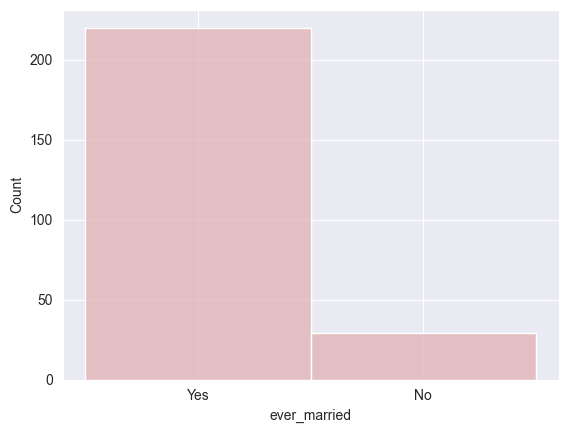

In [43]:
sns.histplot(data = df_original[df_original['stroke'] == 1].ever_married)

In [44]:
df_original["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [45]:
print(df.isna().sum())

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                    201
smoking_status           0
stroke               10204
dtype: int64


In [46]:
X = df[['age','gender','bmi']].copy()
X

,age,gender,bmi
0,28.0,Male,31.1
1,33.0,Male,23.9
2,42.0,Female,40.3
3,56.0,Male,28.8
4,24.0,Female,28.8
...,...,...,...
30613,27.0,Female,17.6
30614,49.0,Male,26.7
30615,3.0,Female,18.3
30616,31.0,Male,28.7


In [47]:
Dtr = DecisionTreeRegressor(random_state=42)

X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

missing_rows = X[X.bmi.isna()]

X = X[~X.bmi.isna()]
Y = X.pop('bmi')
Dtr.fit(X,Y)

predicted_bmi = pd.Series(Dtr.predict(missing_rows[['age','gender']]),index=missing_rows.index)
df.loc[missing_rows.index,'bmi'] = predicted_bmi

In [48]:
print(df.isna().sum())

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                      0
smoking_status           0
stroke               10204
dtype: int64


In [49]:
# we replace other with female (no offense females are more than males)
df.gender.replace('Other','Female', inplace = True) 

# we create two new feature instead of body mass index (bmi): morbid and obese
df['morbid'] = np.where(df.bmi>40,1,0)
df['obese'] = np.where(df.bmi>30,1,0)

In [50]:
# each risk factor is collected as a sum and collectively forms a risk_factors feature
# https://www.kaggle.com/competitions/playground-series-s3e2/discussion/377370
df['risk_factors'] = df[[
    'avg_glucose_level', 'age', 'bmi', 
    'hypertension', 'heart_disease', 
    'smoking_status'
]].apply(
    lambda x: \
    0 + (1 if x.avg_glucose_level > 99 else 0) + \
    (1 if x.age > 45 else 0) + (1 if x.bmi > 24.99 else 0) + \
    (1 if x.hypertension == 1 else 0) + \
    (1 if x.heart_disease == 1 else 0) + \
    (1 if x.smoking_status in ['formerly smoked', 'smokes'] else 0),
    axis=1
)

In [51]:
# label encoding
# order by stroke likelihood
df['gender'] = df['gender'].map({'Female' : 0, 'Male' : 1})
df['ever_married'] = df['ever_married'].map({'No' : 0, 'Yes' : 1})
df['work_type'] = df['work_type'].map({'Never_worked' : 0, 'children' : 1, 'Private' : 2, 'Govt_job' : 3, 'Self-employed' : 4})
#df['smoking_status'] = df['smoking_status'].map({'Unknown' : 0, 'never smoked' : 1, 'smokes' : 3, 'formerly smoked' : 2})
df = pd.get_dummies(data=df, columns=['smoking_status'])

df.drop(['id','Residence_type'],axis=1,inplace=True)

In [52]:
train = df[df['stroke'].notnull()]
test = df[df['stroke'].isnull()].drop('stroke',axis=1)

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20414 entries, 0 to 20413
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          20414 non-null  int64  
 1   age                             20414 non-null  float64
 2   hypertension                    20414 non-null  int64  
 3   heart_disease                   20414 non-null  int64  
 4   ever_married                    20414 non-null  int64  
 5   work_type                       20414 non-null  int64  
 6   avg_glucose_level               20414 non-null  float64
 7   bmi                             20414 non-null  float64
 8   stroke                          20414 non-null  float64
 9   morbid                          20414 non-null  int32  
 10  obese                           20414 non-null  int32  
 11  risk_factors                    20414 non-null  int64  
 12  smoking_status_Unknown          

In [54]:
train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,stroke,morbid,obese,risk_factors,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,28.0,0,0,1,2,79.53,31.1,0.0,0,1,1,0,0,1,0
1,1,33.0,0,0,1,2,78.44,23.9,0.0,0,0,1,0,1,0,0
2,0,42.0,0,0,1,2,103.00,40.3,0.0,1,1,2,1,0,0,0
3,1,56.0,0,0,1,2,64.87,28.8,0.0,0,0,2,0,0,1,0
4,0,24.0,0,0,0,2,73.36,28.8,0.0,0,0,1,0,0,1,0


In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 20414 to 30617
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          10204 non-null  int64  
 1   age                             10204 non-null  float64
 2   hypertension                    10204 non-null  int64  
 3   heart_disease                   10204 non-null  int64  
 4   ever_married                    10204 non-null  int64  
 5   work_type                       10204 non-null  int64  
 6   avg_glucose_level               10204 non-null  float64
 7   bmi                             10204 non-null  float64
 8   morbid                          10204 non-null  int32  
 9   obese                           10204 non-null  int32  
 10  risk_factors                    10204 non-null  int64  
 11  smoking_status_Unknown          10204 non-null  uint8  
 12  smoking_status_formerly smok

In [56]:
test.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,morbid,obese,risk_factors,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
20414,0,57.0,0,0,1,2,82.54,33.4,0,1,2,1,0,0,0
20415,1,70.0,1,0,1,2,72.06,28.5,0,0,3,1,0,0,0
20416,0,5.0,0,0,0,1,103.72,19.5,0,0,1,1,0,0,0
20417,0,56.0,0,0,1,3,69.24,41.4,1,1,3,0,0,0,1
20418,1,32.0,0,0,1,2,111.15,30.1,0,1,3,0,0,0,1


In [57]:
X = train.drop(['stroke'], axis=1).copy()
Y = train['stroke'].copy() 
X_test = test.copy()

In [58]:
X.hypertension.value_counts()

0    19155
1     1259
Name: hypertension, dtype: int64

In [59]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

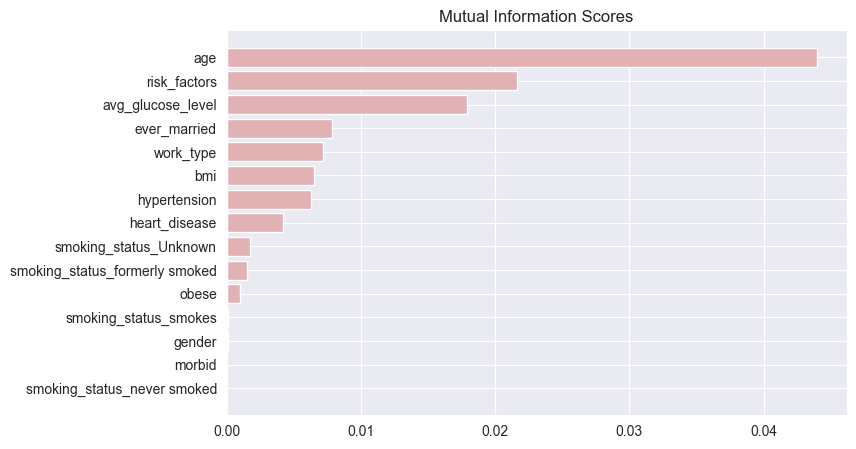

In [60]:
a = train.copy()
b = a.pop('stroke')
mi_scores = make_mi_scores(a, b)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

fold : 1
score : 0.8755882506922307
-----------------------------------------------------
fold : 2
score : 0.8797830816483235
-----------------------------------------------------
fold : 3
score : 0.8723997719710543
-----------------------------------------------------
fold : 4
score : 0.8842155050465603
-----------------------------------------------------
fold : 5
score : 0.8734028068705487
-----------------------------------------------------
Score over 5-folds : 0.8770778832457434


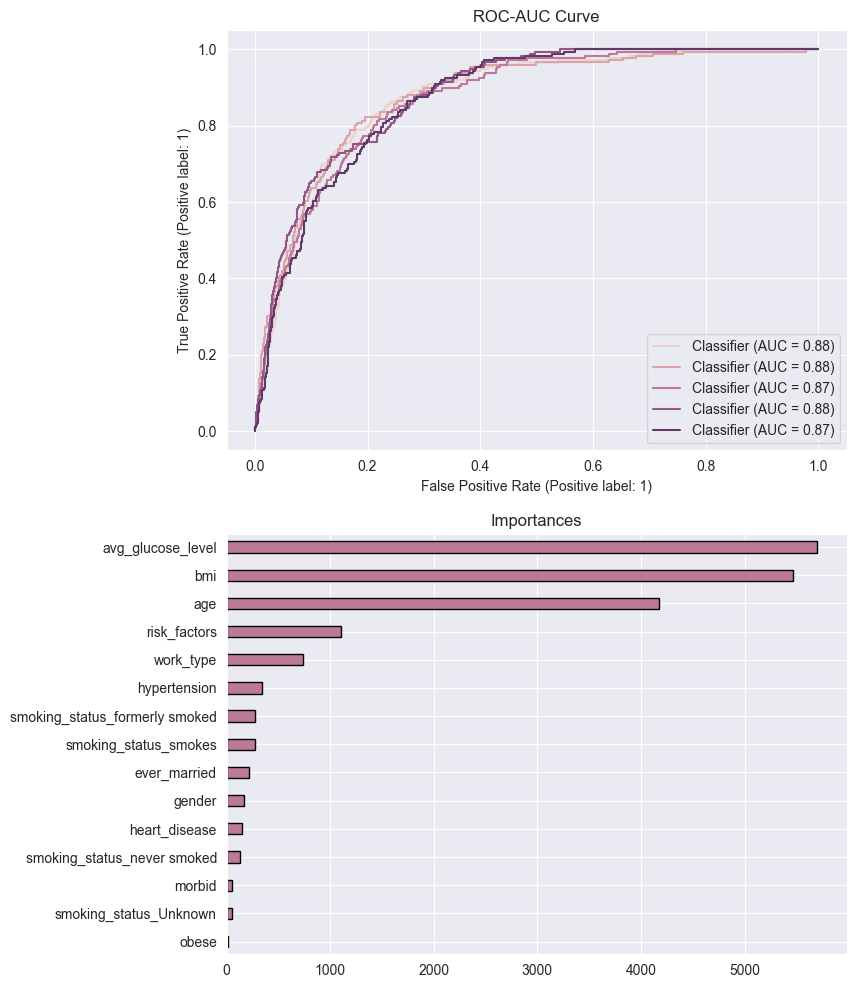

In [61]:
colors = sns.cubehelix_palette()

sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 1, figsize=(8,12))
ax[0].set_title('ROC-AUC Curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate');
ax[1].set_title('Importances')

# split into X, Y
X = train.drop(['stroke'], axis=1).copy()
Y = train['stroke'].copy()
X_test = test.copy()

lgb_cv_scores = list()
lgb_importances = list()
lgb_preds_test = list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for fold, (train_index, valid_index) in enumerate(skf.split(X, Y)):
    
    # split into train, valid
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    Y_train, Y_valid = Y.iloc[train_index], Y.iloc[valid_index]

    # model
    model = LGBMClassifier(n_estimators = 1000,
                            max_depth = 7,
                            learning_rate = 0.01,
                            num_leaves = 20,
                            reg_alpha = 3,
                            reg_lambda = 3,
                            subsample = 0.7,
                            colsample_bytree = 0.7)
    
    # train
    model.fit(X_train, Y_train)

    # importances
    lgb_importances.append(model.feature_importances_)
    
    # validation
    lgb_pred_valid = model.predict_proba(X_valid)[:, 1]
    lgb_cv_scores.append(roc_auc_score(Y_valid, lgb_pred_valid))
    RocCurveDisplay.from_predictions(Y_valid, lgb_pred_valid, color=colors[fold], ax=ax[0])

    # test
    lgb_pred_test = model.predict_proba(X_test)[:, 1]
    lgb_preds_test.append(lgb_pred_test)

    print(f'fold : {(fold % 5 + 1)}')
    print(f'score : {lgb_cv_scores[-1]}')
    print('-----------------------------------------------------')

# importances
df_importances = pd.DataFrame(lgb_importances, columns=X.columns).apply(np.mean, axis=0).sort_values()
df_importances.plot(kind='barh', align='center', width=0.4, ax=ax[1], color=colors[2], edgecolor='black')

# folds score
lgb_cv_score = np.mean(lgb_cv_scores)    
print(f'Score over 5-folds : {lgb_cv_score}')

In [62]:
import pickle

filename = 'stroke_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [63]:
lgb_preds_test = list()
lgb_pred_test = model.predict_proba(X_test)[:, 1]
lgb_preds_test.append(lgb_pred_test)

In [64]:
lgb_preds_test

[array([0.0242589 , 0.23045784, 0.00111127, ..., 0.00116119, 0.00233616,
        0.00097506])]

In [65]:
test.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 20414 to 30617
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          10204 non-null  int64  
 1   age                             10204 non-null  float64
 2   hypertension                    10204 non-null  int64  
 3   heart_disease                   10204 non-null  int64  
 4   ever_married                    10204 non-null  int64  
 5   work_type                       10204 non-null  int64  
 6   avg_glucose_level               10204 non-null  float64
 7   bmi                             10204 non-null  float64
 8   morbid                          10204 non-null  int32  
 9   obese                           10204 non-null  int32  
 10  risk_factors                    10204 non-null  int64  
 11  smoking_status_Unknown          10204 non-null  uint8  
 12  smoking_status_formerly smok

In [66]:
serie = pd.DataFrame(lgb_preds_test)
serie = serie.T
serie

,0
0,0.024259
1,0.230458
2,0.001111
3,0.052274
4,0.009139
...,...
10199,0.001226
10200,0.019361
10201,0.001161
10202,0.002336


In [67]:
serie.mean()

0    0.038188
dtype: float64

In [68]:
df_submission['stroke'] = serie

In [69]:
df_submission.to_csv('submission.csv', index = False)